In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.grid_search import GridSearchCV
import pydot
from sklearn.cross_validation import train_test_split, KFold
%matplotlib inline
#Print all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/Users/siddharthamamidanna/anaconda/envs/dsienv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Couldn't import dot_parser, loading of dot files will not be possible.


/Users/siddharthamamidanna/anaconda/envs/dsienv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/siddharthamamidanna/anaconda/envs/dsienv/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Problem statement: Assuming there was no human negligence (functioning car and no intoxication), predict vehicular occupant fatalities using weather, car type, and manner of collision among other predictors. 

In [273]:
# Import accident
df_accident = pd.read_csv('accident.csv')

# Exclude drunk drivers, rows where permvit ==0, parked/working vehicles, 
print "All drunks table size", df_accident.shape
# Filter out for Drunk drivers, , parked vehicles
df_accident = df_accident[(df_accident.DRUNK_DR == 0) & \
                          (df_accident.PERMVIT != 0) & (df_accident.PVH_INVL == 0) & (df_accident.PEDS == 0)\
                         & (df_accident.PERNOTMVIT == 0)]
print "No drunks table size", df_accident.shape

All drunks table size (32166, 52)
No drunks table size (17091, 52)


# Filtered out rows of drunk driving

In [274]:
# sort by st_case
df_accident = df_accident.sort_values(by='ST_CASE')
# Table sample
df_accident.head()

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,RUR_URB,FUNC_SYS,RD_OWNER,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
1,1,10002,1,1,0,0,0,1,1,83,0,1,1,2015,5,22,13,1,1,1,1,1,I-65,NaN,3604,34.910442,-86.908708,0,34,0,0,1,1,0,3,2,10,0,10,0,0000000,99,99,22,20,88,88,0,0,0,1,0
4,1,10005,2,2,0,0,0,2,2,45,2050,7,1,2015,4,7,9,0,2,3,1,2,US-SR 53,HINTON WATERS AVE,308,31.319331,-85.515100,0,12,6,0,2,3,0,1,1,1,0,1,0,0000000,99,99,7,16,88,88,0,0,0,1,0
5,1,10006,1,1,0,0,0,2,2,111,0,8,1,2015,5,9,59,0,1,5,2,4,CR-82,NaN,0,33.438494,-85.389267,0,1,0,0,1,1,0,4,1,1,0,1,0,0000000,99,99,10,17,99,99,0,0,0,1,0
6,1,10007,1,1,0,0,0,2,2,89,1730,8,1,2015,5,18,33,1,2,3,1,2,US-SR 2,NaN,1030,34.773044,-86.527664,0,43,0,0,1,1,0,4,3,1,0,1,0,0000000,99,99,18,38,99,99,0,0,0,1,0
8,1,10009,1,1,0,0,0,1,1,117,47,13,1,2015,3,8,0,1,2,3,1,2,US-SR 3,NaN,2520,33.236100,-86.813922,0,23,0,0,1,1,0,4,1,10,0,10,0,0000000,99,99,8,3,88,88,0,0,0,1,0


In [275]:
# Read Vehicle spreadsheet into dataframe
df_vehicle = pd.read_csv('vehicle.csv')
# Sort df_vehicle by st_case
df_vehicle = df_vehicle.sort_values(by='ST_CASE')
# Print data frame dimensions
print df_vehicle.shape

# Read Persons spreadsheet into dataframe
df_person = pd.read_csv('person.csv')
# Sort persons by st_case
df_person = df_person.sort_values(by='ST_CASE')
# Print data frame dimensions
print df_person.shape

# Read Factor spreadsheet into dataframe
df_factor = pd.read_csv('df_factor.csv')
df_factor = df_factor[df_factor.columns[1:]].sort_values(by='ST_CASE')
# Print data frame dimensions
print df_factor.shape

(48923, 102)
(80587, 68)
(48985, 4)


In [276]:
# Filter for rows where nothing was wrong with vehicle, i.e. ST_CASES where MFACTOR == 0. 
# We'll only consider these ST_cases in the main data set df_vehicle_accident_person_merged
ST_CASE_GOOD_CONDITION_CARS = df_factor[df_factor.MFACTOR == '0'].ST_CASE.unique().tolist()
len(ST_CASE_GOOD_CONDITION_CARS)

29619

In [277]:
# Remove clerical columns that have no meaning.
df_vehicle = df_vehicle[[d for d in df_vehicle.columns if not (d.startswith('VIN_') | d.startswith('PREV') 
                                       | d.startswith('L_') | d.startswith('P_'))]]
# Remove vehicles operated by drunk drivers.
df_vehicle = df_vehicle[df_vehicle.DR_DRINK == 0]

In [278]:
# Remove people drinking and taking drugs. 

df_person= df_person[df_person.DRINKING == 0]
df_person  = df_person[[d for d in df_person.columns if not (d.startswith('DRUG'))]]

# I found common columns between tables and used them for joins each time, shooting for a more clearly defined join. I was mainly interested in 'MAN_COLL' as that was a collision orientation description in common with all tables I was interested in. 

In [279]:
# Find columns in common between accident spreadsheet and vehicle spreadsheet. 
common_cols_accident_vehicle = list(set(df_vehicle.columns) & set(df_accident.columns))
print common_cols_accident_vehicle

['MAN_COLL', 'HOUR', 'MONTH', 'STATE', 'VE_FORMS', 'HARM_EV', 'ST_CASE', 'DAY', 'MINUTE']


In [280]:
# Compare table dimensions to see which should be left/right. 
df_vehicle.shape, df_accident.shape

((39814, 76), (17091, 52))

In [281]:
# Join vehicle and accident data frames on common columns
df_vehicle_accident_merged = df_vehicle.merge(right= df_accident,on=common_cols_accident_vehicle, how='left' )
df_vehicle_accident_merged.shape

(39814, 119)

In [282]:
# Find columns in common with table created above, and person
common_cols_df_accident_vehcile_merged_and_person =  list(set(df_vehicle_accident_merged.columns) & set(df_person.columns))

In [285]:
# Join table created above with person
df_vehicle_accident_person_merged = df_vehicle_accident_merged.merge(right= df_person,on= common_cols_df_accident_vehcile_merged_and_person, how='left' )
df_vehicle_accident_person_merged= df_vehicle_accident_person_merged[(df_vehicle_accident_person_merged.corr().columns)]
df_vehicle_accident_person_merged.shape

(41630, 149)

In [294]:
nominal_or_not_categories = pd.Series(df_vehicle_accident_person_merged.columns)
nominal_or_not_categories.to_csv('df_vehicle_accident_person_merged_states.csv')

# Had to manually input null values, as documentation had specified ones.

In [252]:
df_vehicle_accident_person_merged.MAN_COLL = \
df_vehicle_accident_person_merged['MAN_COLL'].replace([11, 98,99], np.nan)

df_vehicle_accident_person_merged[['FUNC_SYS', 'HARM_EV', 'RELJCT2', 'TYP_INT', 'REL_ROAD', 'WEATHER','WEATHER1',\
                                   'WEATHER2', 'NUMOCCS',
'IMPACT1', 'VSURCOND', 'ACC_TYPE', 'SEAT_POS']] = df_vehicle_accident_person_merged[[\
        'FUNC_SYS', 'HARM_EV', 'RELJCT2', 'TYP_INT', 'REL_ROAD', 'WEATHER','WEATHER1','WEATHER2', 'NUMOCCS',\
'IMPACT1', 'VSURCOND', 'ACC_TYPE', 'SEAT_POS']].replace([98,99], np.nan)

df_vehicle_accident_person_merged[['BODY_TYP', 'REST_USE', 'AIR_BAG']]= df_vehicle_accident_person_merged\
[['BODY_TYP', 'REST_USE', 'AIR_BAG']].replace([97, 98, 99],np.nan)

df_vehicle_accident_person_merged[['RELJCT1', 'NHS', 'HIT_RUN', 'TOW_VEH',  'UNDERIDE']]= \
df_vehicle_accident_person_merged[['RELJCT1', 'NHS', 'HIT_RUN', 'TOW_VEH',  'UNDERIDE']].replace(9, np.nan) 

df_vehicle_accident_person_merged[['LGT_COND','VPAVETYP', 'EJECTION']] = \
df_vehicle_accident_person_merged[['LGT_COND','VPAVETYP', 'EJECTION']].replace([7,8,9],np.nan)

df_vehicle_accident_person_merged[['HOUR','MINUTE','CF1','CF2','CF3', 'M_HARM']] = \
df_vehicle_accident_person_merged[['HOUR','MINUTE','CF1','CF2','CF3', 'M_HARM']].replace(99,np.nan) 

df_vehicle_accident_person_merged[['ROUTE', 'RELJCT1', 'GVWR', 'EMER_USE', 'SPEEDREL', 'VTRAFWAY', \
                                   'VALIGN', 'VPROFILE', 'SEX', 'INJ_SEV',
'EJ_PATH', 'DEFORMED', 'VNUM_LAN']] = df_vehicle_accident_person_merged[['ROUTE', 'RELJCT1', 'GVWR',\
                        'EMER_USE', 'SPEEDREL', 'VTRAFWAY', 'VALIGN', 'VPROFILE', 'SEX', 'INJ_SEV',
'EJ_PATH', 'DEFORMED', 'VNUM_LAN']].replace([8,9], np.nan)

# df_vehicle_accident_person_merged['LATITUDE'] = df_vehicle_accident_person_merged['LATITUDE'].replace(99.9999, np.nan)

# df_vehicle_accident_person_merged['LONGITUD'] = df_vehicle_accident_person_merged['LONGITUD'].replace(999.9999, np.nan)

df_vehicle_accident_person_merged[['ARR_HOUR', 'ARR_MIN', 'HOSP_HR', 'HOSP_MN']]= \
df_vehicle_accident_person_merged[['ARR_HOUR', 'ARR_MIN', 'HOSP_HR', 'HOSP_MN']].replace([88, 99],np.nan)

df_vehicle_accident_person_merged[['TRAV_SP', 'DR_HGT','AGE']] = df_vehicle_accident_person_merged\
[['TRAV_SP', 'DR_HGT','AGE']].replace([998, 999],np.nan)

df_vehicle_accident_person_merged['DR_WGT'] = df_vehicle_accident_person_merged['DR_WGT'].replace([997,998,999],np.nan)



In [169]:
# Dropped null rows
df_vehicle_accident_person_merged = df_vehicle_accident_person_merged.dropna(axis=0)
df_vehicle_accident_person_merged.shape

(1472, 63)

In [170]:
def death_conv(ser):
    """Makes deaths a binary value"""
    if ser>0:
        return 1
    else:
        return 0
df_vehicle_accident_person_merged['DEATHS_BINARY']= df_vehicle_accident_person_merged.DEATHS.apply(death_conv)

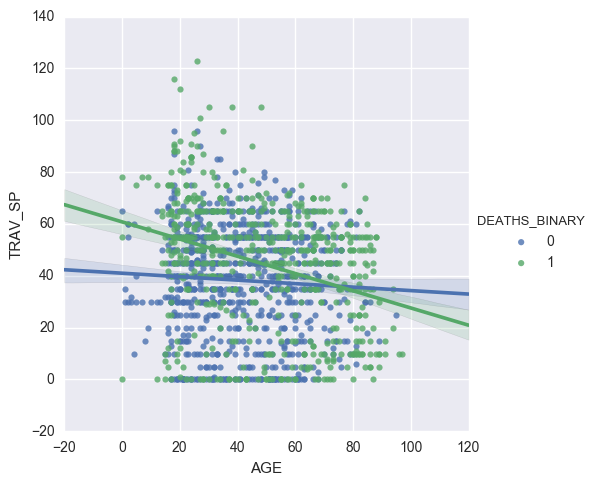

In [171]:
# Regression curve of deaths and travel speed.
sns.set(color_codes=True)
g_deaths_binary = sns.lmplot(x='AGE', y='TRAV_SP',\
                             data=df_vehicle_accident_person_merged, hue='DEATHS_BINARY', fit_reg=True)
sns.plt.savefig('Age_travelsp_death_binary.png')
sns.plt.show()


In [172]:
# Create deaths binary column
df_vehicle_accident_person_merged['SPEEDREL_BINARY'] = df_vehicle_accident_person_merged.SPEEDREL.apply(death_conv)

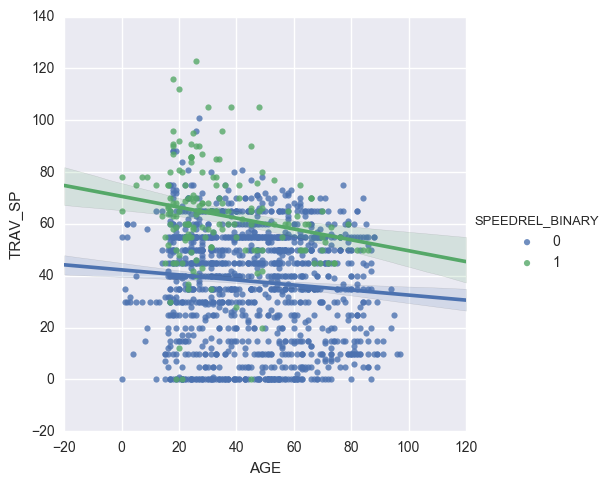

In [173]:
# Regression of age vs travel speed.
g_speed_rel = sns.lmplot(x='AGE', y='TRAV_SP', data=df_vehicle_accident_person_merged, hue='SPEEDREL_BINARY', fit_reg=True)
sns.plt.savefig('Travel_speed_rel.png')

In [174]:
def sex_conv(seri):
    """ Clears up gender column"""
    if seri == 1.0:
        return 0
    if seri == 2.0:
        return 1
df_vehicle_accident_person_merged.SEX  = df_vehicle_accident_person_merged.SEX.apply(sex_conv)

# def body_typ_conv(seri):
#     if seri

In [175]:
df_vehicle_accident_person_merged.columns

Index([u'STATE', u'PERSONS', u'PERMVIT', u'HOUR', u'MINUTE', u'MONTH',
       u'DAY_WEEK', u'ROUTE', u'FUNC_SYS', u'NHS', u'HARM_EV', u'MAN_COLL',
       u'RELJCT1', u'RELJCT2', u'TYP_INT', u'REL_ROAD', u'WRK_ZONE',
       u'LGT_COND', u'WEATHER', u'WEATHER1', u'WEATHER2', u'SCH_BUS',
       u'ARR_HOUR', u'ARR_MIN', u'HOSP_HR', u'HOSP_MN', u'CF1', u'CF2', u'CF3',
       u'NUMOCCS', u'HIT_RUN', u'BODY_TYP', u'TOW_VEH', u'J_KNIFE', u'GVWR',
       u'HAZ_INV', u'EMER_USE', u'TRAV_SP', u'UNDERIDE', u'ROLLOVER',
       u'IMPACT1', u'DEFORMED', u'M_HARM', u'FIRE_EXP', u'DEATHS', u'DR_HGT',
       u'DR_WGT', u'SPEEDREL', u'VTRAFWAY', u'VNUM_LAN', u'VALIGN',
       u'VPROFILE', u'VPAVETYP', u'VSURCOND', u'ACC_TYPE', u'AGE', u'SEX',
       u'INJ_SEV', u'SEAT_POS', u'REST_USE', u'AIR_BAG', u'EJECTION',
       u'EJ_PATH', u'DEATHS_BINARY', u'SPEEDREL_BINARY'],
      dtype='object')

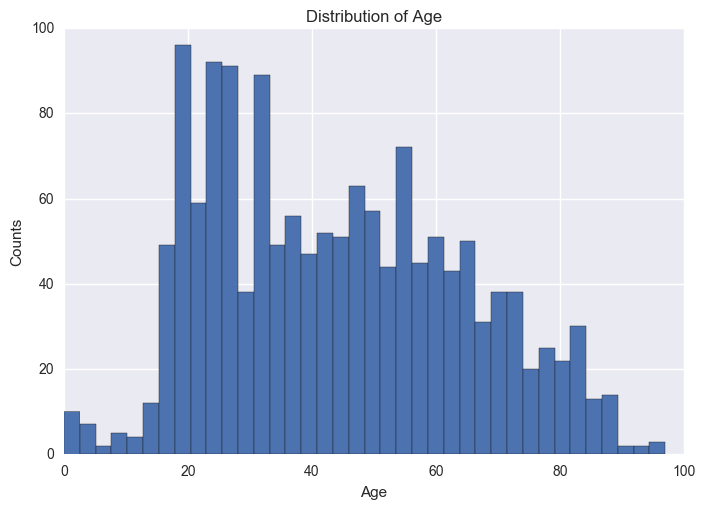

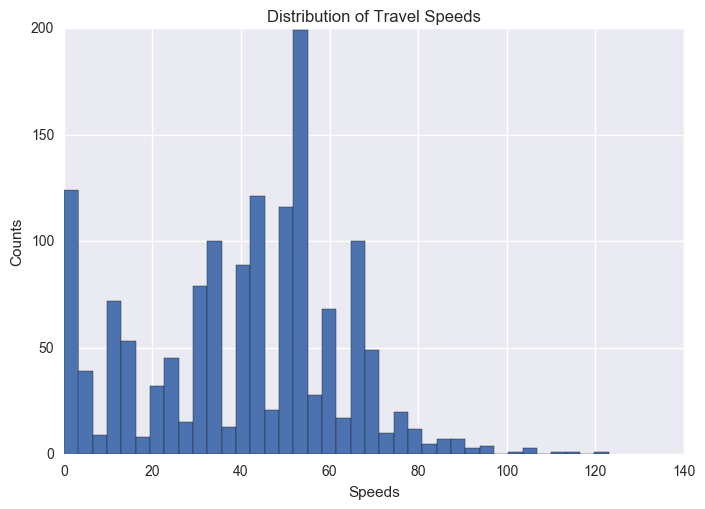

In [176]:
# Plot histogram of age
plt.hist(df_vehicle_accident_person_merged.AGE, bins=(38))
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Counts')
plt.savefig('Histo_AGE.png')
plt.show()

# Plot histogram of speeds
plt.hist(df_vehicle_accident_person_merged.TRAV_SP, bins=(38))
plt.title('Distribution of Travel Speeds')
plt.xlabel('Speeds')
plt.ylabel('Counts')
plt.savefig('Histo_Speeds.png')
plt.show()


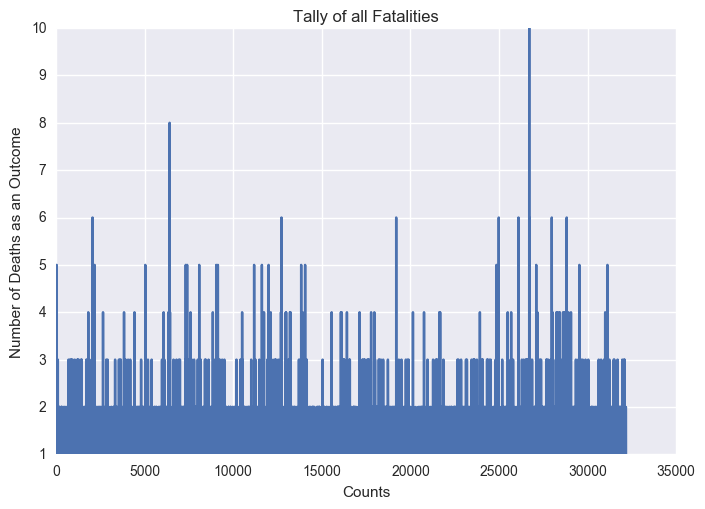

In [177]:
plt.plot(df_accident.FATALS)
plt.title("Tally of all Fatalities")
plt.xlabel("Counts")
plt.ylabel("Number of Deaths as an Outcome")
plt.savefig('Number of Deaths as an Outcome.png')
plt.show()

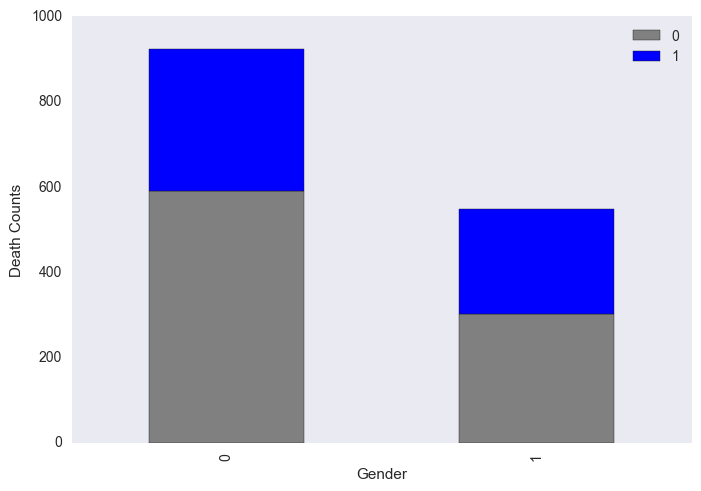

In [178]:
# Plot of fatalities by gender
avar = df_vehicle_accident_person_merged.groupby(['SEX','DEATHS_BINARY']).DEATHS_BINARY.count()
avar.unstack().plot(kind='bar', stacked=True, color=['grey','blue'], grid=False)
plt.legend()
plt.xlabel('Gender')
plt.ylabel('Death Counts')
plt.savefig('Survival_by_gender.png')
plt.show()


In [179]:
# Get column index for DEATHS
for i,e in enumerate(df_vehicle_accident_person_merged.columns):
    if e == 'DEATHS':
        print i

death_corr = df_vehicle_accident_person_merged.corr()#.iloc[:, 44]
# death_corr.sort_values(ascending=False)
death_corr#.sort_values()
#LOGISTIC PREDICTORS
#HOUR, ROUTE, HARM_EV, MAN_COLL, TYP_INT, REL_ROAD, WEATHER2, ARR_HOUR, 
#TRAV_SP, ROLLOVER, DEFORMED, M_HARM, SPEEDREL, VNUM_LAN, VALIGN, ACC_TYPE, 
#AGE, INJ_SEV, NUMOCCS, HIT_RUN, BODY_TYP, TOW_VEH, J_KNIFE, GWR, 
#REST_USE, AIR_BAG,EJECTION ,EJ_PATH

44


,STATE,PERSONS,PERMVIT,HOUR,MINUTE,MONTH,DAY_WEEK,ROUTE,FUNC_SYS,NHS,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,REL_ROAD,WRK_ZONE,LGT_COND,WEATHER,WEATHER1,WEATHER2,SCH_BUS,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,NUMOCCS,HIT_RUN,BODY_TYP,TOW_VEH,J_KNIFE,GVWR,HAZ_INV,EMER_USE,TRAV_SP,UNDERIDE,ROLLOVER,IMPACT1,DEFORMED,M_HARM,FIRE_EXP,DEATHS,DR_HGT,DR_WGT,SPEEDREL,VTRAFWAY,VNUM_LAN,VALIGN,VPROFILE,VPAVETYP,VSURCOND,ACC_TYPE,AGE,SEX,INJ_SEV,SEAT_POS,REST_USE,AIR_BAG,EJECTION,EJ_PATH,DEATHS_BINARY,SPEEDREL_BINARY
STATE,1.000000,-0.020883,-0.020883,0.026159,0.055951,0.068457,-0.032836,-0.119512,0.049697,-0.063817,0.067275,0.018447,0.035760,-0.072027,-0.002871,0.023260,0.013401,-0.060147,0.252711,0.040166,0.373205,-0.049048,0.045116,-0.009696,0.054078,0.002516,-0.143256,-0.005117,NaN,-0.040222,-0.056891,0.025025,0.014637,0.027069,0.020093,0.003815,0.049777,0.079671,0.051381,0.025907,-0.054115,0.121825,0.047083,-0.008649,0.049998,0.040904,0.057148,-0.043027,-0.096617,-0.156667,0.043099,-0.068540,0.033506,0.065727,0.017520,0.075025,-0.007090,0.095487,-0.080864,0.024337,-0.087338,-0.010281,-0.013481,0.060591,-0.045843
PERSONS,-0.020883,1.000000,1.000000,0.074512,-0.012022,-0.064678,0.109317,-0.086475,-0.093632,0.080753,-0.064197,0.138654,0.114038,0.055378,0.043711,-0.105380,0.013689,-0.101820,0.090818,0.140407,0.004227,0.011249,0.081270,-0.085654,0.091276,-0.009319,0.130275,0.021815,NaN,0.514654,-0.023149,0.032229,0.012143,0.064689,0.071174,-0.010200,-0.014096,-0.026368,0.002041,-0.030435,-0.031932,0.149381,-0.041464,0.007466,0.012873,-0.047422,-0.011606,0.061394,0.078298,0.028195,-0.041704,-0.023747,-0.058201,0.127141,0.147440,-0.102483,0.061744,-0.026107,0.368400,-0.065793,-0.099424,-0.028903,-0.028109,-0.015115,0.053826
PERMVIT,-0.020883,1.000000,1.000000,0.074512,-0.012022,-0.064678,0.109317,-0.086475,-0.093632,0.080753,-0.064197,0.138654,0.114038,0.055378,0.043711,-0.105380,0.013689,-0.101820,0.090818,0.140407,0.004227,0.011249,0.081270,-0.085654,0.091276,-0.009319,0.130275,0.021815,NaN,0.514654,-0.023149,0.032229,0.012143,0.064689,0.071174,-0.010200,-0.014096,-0.026368,0.002041,-0.030435,-0.031932,0.149381,-0.041464,0.007466,0.012873,-0.047422,-0.011606,0.061394,0.078298,0.028195,-0.041704,-0.023747,-0.058201,0.127141,0.147440,-0.102483,0.061744,-0.026107,0.368400,-0.065793,-0.099424,-0.028903,-0.028109,-0.015115,0.053826
HOUR,0.026159,0.074512,0.074512,1.000000,-0.055293,0.039693,0.031216,0.035111,0.064783,0.018577,-0.047249,-0.016246,-0.045460,-0.030298,-0.000219,-0.004564,-0.026401,0.050820,-0.031369,-0.006049,-0.038280,-0.025447,0.942885,-0.046048,0.881326,0.022472,-0.058851,-0.073121,NaN,0.103785,0.003853,-0.063241,-0.055762,-0.063372,-0.096939,-0.006017,-0.044487,0.010268,-0.015694,-0.017231,-0.031535,-0.026236,-0.090492,0.000450,-0.055327,-0.031308,-0.017749,-0.027449,0.014863,-0.017059,-0.057984,-0.032919,0.031751,-0.092248,-0.004135,-0.042928,0.036672,-0.118953,0.036427,-0.047971,0.074041,-0.038498,-0.025368,-0.070166,-0.017985
MINUTE,0.055951,-0.012022,-0.012022,-0.055293,1.000000,0.053111,0.026248,0.004059,-0.004905,0.012365,-0.044985,-0.005712,0.008270,-0.048036,-0.018151,0.017222,-0.014062,-0.024221,0.010445,0.014938,-0.031603,0.056373,-0.014638,0.131804,0.000096,-0.075151,-0.074911,-0.048264,NaN,0.052049,-0.019052,-0.022385,-0.030607,-0.011799,-0.010375,0.018179,-0.037826,0.042579,-0.010386,0.028671,0.027178,0.015886,-0.000502,-0.010906,-0.000441,0.013897,0.004396,0.018758,0.018978,0.007159,0.054562,0.008361,0.006411,-0.000391,-0.002330,0.002460,-0.002900,0.020826,0.020293,-0.015740,-0.000281,-0.001871,-0.019005,0.034469,0.019568
MONTH,0.068457,-0.064678,-0.064678,0.039693,0.053111,1.000000,-0.022095,0.005098,0.017071,-0.008709,-0.009967,0.011808,-0.004071,0.010729,0.037986,-0.028822,0.021556,0.046196,0.080547,0.038216,0.062785,0.013525,0.030480,0.015210,0.031124,0.023802,0.000514,-0.033683,NaN,0.009095,-0.017490,0.029623,0.026554,-0.007943,0.008731,0.035917,-0.003840,0.028962,-0.001169,0.054439,0.005297,-0.01878

In [180]:
import sklearn
from sklearn.model_selection import train_test_split
import sklearn.linear_model

# Trial with non human elements.

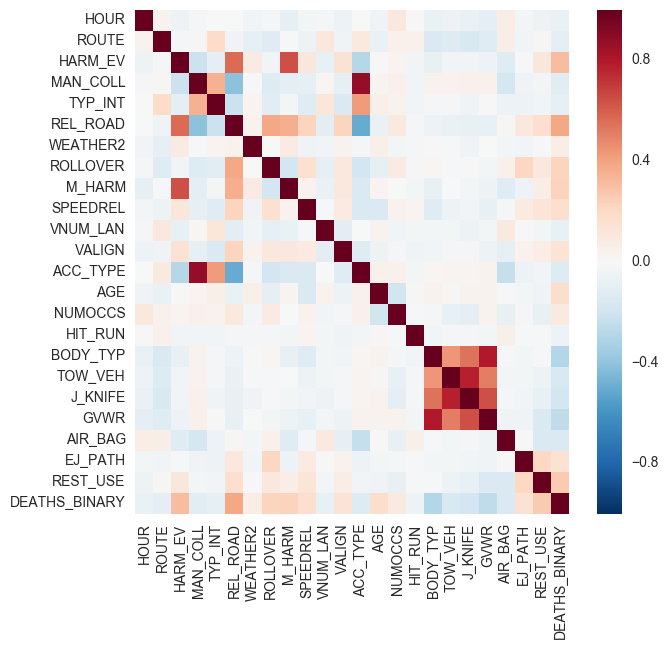

In [181]:
# Create df with train and test variables.
train_and_test_vars = df_vehicle_accident_person_merged[['HOUR', 'ROUTE', 'HARM_EV', 'MAN_COLL', 'TYP_INT', 'REL_ROAD', 'WEATHER2', 
'ROLLOVER', 'M_HARM', 'SPEEDREL', 'VNUM_LAN', 'VALIGN', 'ACC_TYPE', 
'AGE', 'NUMOCCS', 'HIT_RUN', 'BODY_TYP', 'TOW_VEH', 'J_KNIFE', 'GVWR', 'AIR_BAG','EJ_PATH', 'REST_USE', 'DEATHS_BINARY']]

# Create figure
sb.plt.figure(figsize=(7,6.5))
sb.heatmap(train_and_test_vars.corr(),robust=True)
sns.plt.savefig('COrrelation_Heat_Map.png')
sb.plt.show()


# We can't accurately predict deaths with non human elements. This is good news because that means there's more we can do. Simply wearing seat belts and helmets can improve survival by 3%, using other non human predictors. 

In [182]:
# Create X variable
X = df_vehicle_accident_person_merged[['HOUR', 'ROUTE', 'HARM_EV', 'MAN_COLL', 'TYP_INT', 'REL_ROAD', 'WEATHER2', 'ARR_HOUR', 
'TRAV_SP', 'ROLLOVER', 'DEFORMED', 'M_HARM', 'SPEEDREL', 'VNUM_LAN', 'VALIGN', 'ACC_TYPE', 
'AGE', 'INJ_SEV', 'NUMOCCS', 'HIT_RUN', 'BODY_TYP', 'TOW_VEH', 'J_KNIFE', 'GVWR', 
'REST_USE', 'AIR_BAG','EJECTION' ,'EJ_PATH']]
# Create target variable
Y = df_vehicle_accident_person_merged.DEATHS_BINARY
#Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3) #train_test_split(X, Y, test_size=0.33)

#Fit model
logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Y_proba = logreg.predict_proba(X_test)

# Model Perormance assessment. 
print sk.metrics.classification_report(Y_test, Y_pred)
print sk.metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
print sk.metrics.accuracy_score(y_true=Y_test, y_pred=Y_pred)
# logreg.feature_importances_

             precision    recall  f1-score   support

          0       0.91      0.90      0.90       267
          1       0.85      0.86      0.85       175

avg / total       0.88      0.88      0.88       442

[[240  27]
 [ 25 150]]
0.882352941176


In [183]:
cm_logreg_all_vars = pd.DataFrame(sk.metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred), columns=['Predicted_0', 'Predicted_1'], index=['True_0','True_1'])
cm_logreg_all_vars

,Predicted_0,Predicted_1
True_0,240,27
True_1,25,150


0.943691813804


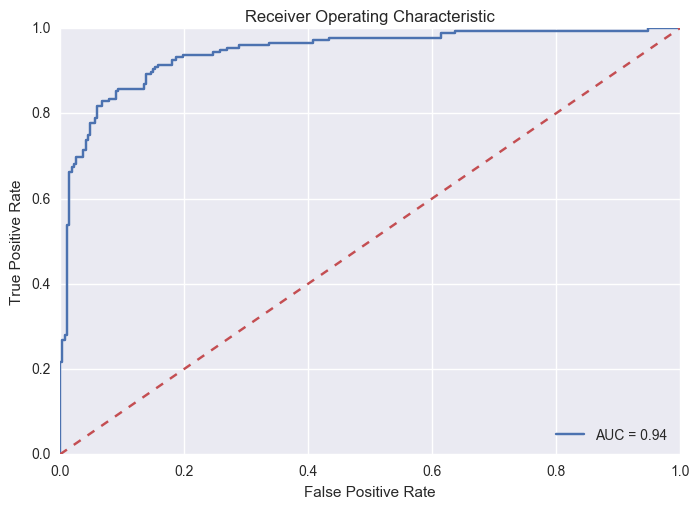

In [184]:
# Print ROC Curves
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test,  Y_proba[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
# print fpr
# print tpr
# print threshold
print roc_auc

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_Curve_Logreg_All_variables.png')
plt.show()


# fig1 = plt.gcf()
# plt.show()
# plt.draw()
# fig1.savefig('tessstttyyy.jpeg', dpi=100)

# WITH 5 VARIABLES

In [185]:
X = df_vehicle_accident_person_merged[['HARM_EV','REL_ROAD','DEFORMED','INJ_SEV','BODY_TYP','REST_USE']]
Y = df_vehicle_accident_person_merged.DEATHS_BINARY
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3) #train_test_split(X, Y, test_size=0.33)

logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Y_proba = logreg.predict_proba(X_test)
print sk.metrics.classification_report(Y_test, Y_pred)
print sk.metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
print sk.metrics.accuracy_score(y_true=Y_test, y_pred=Y_pred)
# logreg.feature_importances_

             precision    recall  f1-score   support

          0       0.90      0.91      0.90       280
          1       0.84      0.82      0.83       162

avg / total       0.88      0.88      0.88       442

[[255  25]
 [ 29 133]]
0.877828054299


In [186]:
cm_logreg_all_vars = pd.DataFrame(sk.metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred), columns=['Predicted_0', 'Predicted_1'], index=['True_0','True_1'])
cm_logreg_all_vars

,Predicted_0,Predicted_1
True_0,255,25
True_1,29,133


0.938899911817


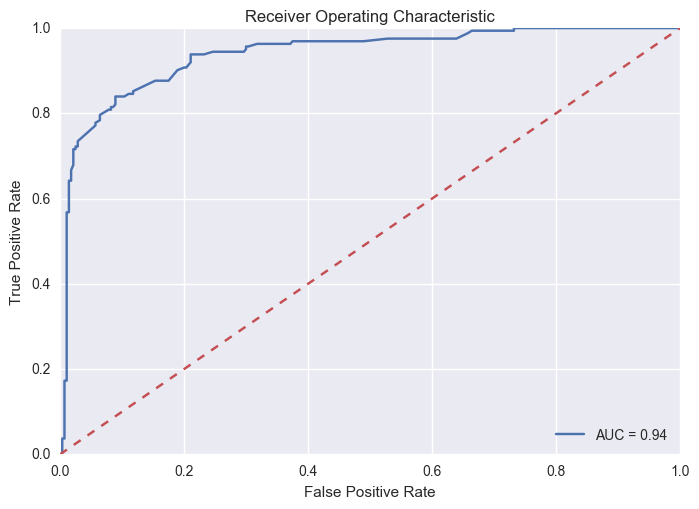

In [187]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, Y_proba[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
# print fpr
# print tpr
# print threshold
print roc_auc

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_Curve_logreg_five_variables.png')
plt.show()


# Five and Ten fold Cross validation

In [188]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 5-fold cross validation
predictions_5 = cross_val_predict(logreg, X_test, Y_test, cv=5)
scores = cross_val_score(logreg, X, Y, cv=5)
accuracy = metrics.accuracy_score(Y_test, predictions_5)
print "Five Fold Cross-validated scores:", scores
print "Five Fold Cross-Predicted Accuracy:", accuracy
# Make cross validated predictions
predictions_10 = cross_val_predict(logreg, X_test, Y_test, cv=10)
scores = cross_val_score(logreg, X, Y, cv=10)
accuracy = metrics.accuracy_score(Y_test, predictions_10)
print "Ten Fold Cross-validated scores:", scores
print "Ten Fold Cross-Predicted Accuracy:", accuracy


Five Fold Cross-validated scores: [ 0.89527027  0.91156463  0.8537415   0.89115646  0.82312925]
Five Fold Cross-Predicted Accuracy: 0.861990950226
Ten Fold Cross-validated scores: [ 0.91275168  0.89115646  0.91836735  0.9047619   0.8707483   0.83673469
  0.88435374  0.89795918  0.79591837  0.85034014]
Ten Fold Cross-Predicted Accuracy: 0.868778280543


Plot both CV scores as scatter with different colors. 

# Ridge and Lasso 

In [189]:
(X.columns)

Index([u'HARM_EV', u'REL_ROAD', u'DEFORMED', u'INJ_SEV', u'BODY_TYP',
       u'REST_USE'],
      dtype='object')

In [190]:
rlm = sklearn.linear_model.RidgeClassifier(alpha=2) #linear_model.Ridge(alpha=4, fit_intercept=True)
ridge_model = rlm.fit(X, Y)
predictions_ridge = ridge_model.predict(X_test)
print ridge_model.coef_, ridge_model.intercept_
print "Accuracy Score:", ridge_model.score(X_test, Y_test)



[[ 0.00192816  0.1812927  -0.00302713  0.38281762 -0.00613353  0.02637148]] [-1.17710759]
Accuracy Score: 0.864253393665


In [191]:
lasso_lm = sklearn.linear_model.LogisticRegression(penalty='l1', C=1)
lasso_lm = lasso_lm.fit(X,Y)
predictions_lasso = lasso_lm.predict(X_test)
print lasso_lm.coef_, lasso_lm.intercept_
print "Accuracy Score:", lasso_lm.score(X_test,Y_test)

[[ 0.02661465  0.78210342  0.29226129  1.28678007 -0.0428632   0.12148435]] [-6.10260511]
Accuracy Score: 0.884615384615


In [192]:
lasso_lm = sklearn.linear_model.LogisticRegression(penalty='l2', C=1)
lasso_lm = lasso_lm.fit(X,Y)
predictions_lasso = lasso_lm.predict(X_test)
print lasso_lm.coef_, lasso_lm.intercept_
print "Accuracy Score:", lasso_lm.score(X_test,Y_test)

[[ 0.02076967  0.75967054  0.03005742  1.29286761 -0.04373741  0.10661053]] [-4.39630016]
Accuracy Score: 0.880090497738


In [193]:
lasso_lm = sklearn.linear_model.LogisticRegressionCV(penalty='l2')
lasso_lm = lasso_lm.fit(X,Y)
predictions_lasso = lasso_lm.predict(X_test)
print lasso_lm.coef_, lasso_lm.intercept_
print "Accuracy Score:", lasso_lm.score(X_test,Y_test)

[[ 0.02841142  0.80374713  0.44825866  1.28850809 -0.04293974  0.12875235]] [-7.10662175]
Accuracy Score: 0.886877828054


lines = [line.split(',')for line in open('distract.txt')]
lines = lines[9:]
a = lines[:4]
counter = 0
for i in a:
    i[3] = i[3].replace('\\\n', '')
    print i

# Feature Selection

In [194]:
a = sklearn.feature_selection.SelectKBest(k=5)
a.fit(X,Y)
(a.transform(X))
# print sklearn.feature_selection.SelectKBest(score_func=(X,Y), k=10)

array([[  8.,   1.,   6.,   0.,  31.],
       [ 42.,   4.,   6.,   4.,   4.],
       [ 42.,   4.,   6.,   3.,   2.],
       ..., 
       [  1.,   4.,   6.,   1.,  31.],
       [ 12.,   1.,   6.,   3.,  31.],
       [ 12.,   1.,   6.,   4.,  31.]])

In [195]:
# Set a minimum threshold of 0.25
sfm = sklearn.feature_selection.SelectFromModel(lasso_lm, threshold=0.25)
sfm.fit(X, Y)
n_features = sfm.transform(X).shape
# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features < 2:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

# Plot the selected two features from X.
# plt.title(
#     "Features selected using SelectFromModel with "
#     "threshold %0.3f." % sfm.threshold)
# feature1 = X_transform[:, 0]
# feature2 = X_transform[:, 1]
# plt.plot(feature1, feature2, 'r.')
# plt.xlabel("Feature number 1")
# plt.ylabel("Feature number 2")
# plt.ylim([np.min(feature2), np.max(feature2)])
# plt.show()

In [196]:
print df_vehicle_accident_person_merged[df_vehicle_accident_person_merged.DEATHS_BINARY == 1].DEFORMED.value_counts()
print df_vehicle_accident_person_merged[df_vehicle_accident_person_merged.DEATHS_BINARY == 0].DEFORMED.value_counts()

6.0    569
4.0      9
0.0      2
2.0      1
Name: DEFORMED, dtype: int64
6.0    587
4.0    163
2.0    125
0.0     16
Name: DEFORMED, dtype: int64


# Decision Tree Classifier!

# FOUND FEATURE IMPORTANCE!!!!!!!!!!!!!!


In [197]:
import sklearn.tree
dtr = sklearn.tree.DecisionTreeClassifier(max_depth=5, max_features=4)
dtr.fit(X_train,Y_train)
dtr_pred = dtr.predict(X_test)


In [198]:
X_train.columns

Index([u'HARM_EV', u'REL_ROAD', u'DEFORMED', u'INJ_SEV', u'BODY_TYP',
       u'REST_USE'],
      dtype='object')

In [199]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, dtr.predict(X_test))
# predicted_cols = ['pred_'+c for c in dtr.classes_]
# pd.DataFrame(conf, index = X_test.index, columns = X_test.columns)
print sklearn.metrics.classification_report(Y_test, dtr_pred)

             precision    recall  f1-score   support

          0       0.87      0.99      0.93       280
          1       0.98      0.75      0.85       162

avg / total       0.91      0.90      0.90       442



# Decision Tree with 5 variables

In [200]:
X = df_vehicle_accident_person_merged[['HARM_EV','REL_ROAD','DEFORMED','INJ_SEV','BODY_TYP','REST_USE']]
Y = df_vehicle_accident_person_merged.DEATHS_BINARY
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3) #train_test_split(X, Y, test_size=0.33)

dtr = sklearn.tree.DecisionTreeClassifier(max_depth=5, max_features=4)
dtr.fit(X_train,Y_train)
dtr_pred = dtr.predict(X_test)
dtr_proba = dtr.predict_proba(X_test)

print sk.metrics.classification_report(Y_test, dtr_pred)
print sk.metrics.confusion_matrix(y_true=Y_test, y_pred=dtr_pred)
print sk.metrics.accuracy_score(y_true=Y_test, y_pred=dtr_pred)
# logreg.feature_importances_

             precision    recall  f1-score   support

          0       0.85      0.99      0.91       266
          1       0.98      0.74      0.84       176

avg / total       0.90      0.89      0.89       442

[[263   3]
 [ 46 130]]
0.889140271493


In [201]:
# compute the feature importances
pd.DataFrame({'feature':X.columns,
              'importance':float(dtr.feature_importances_[0])})

,feature,importance
0,HARM_EV,0.021293
1,REL_ROAD,0.021293
2,DEFORMED,0.021293
3,INJ_SEV,0.021293
4,BODY_TYP,0.021293
5,REST_USE,0.021293


In [202]:
cm_logreg_all_vars = pd.DataFrame(sk.metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred), columns=['Predicted_0', 'Predicted_1'], index=['True_0','True_1'])
cm_logreg_all_vars

,Predicted_0,Predicted_1
True_0,171,95
True_1,113,63


0.915723257006


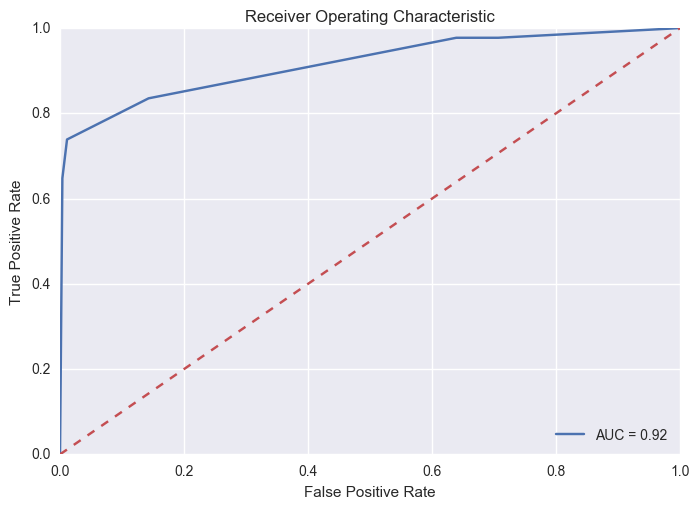

In [203]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test,  dtr_proba[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
# print fpr
# print tpr
# print threshold
print roc_auc

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_curve_decision_trees_five_vars.png')
plt.show()


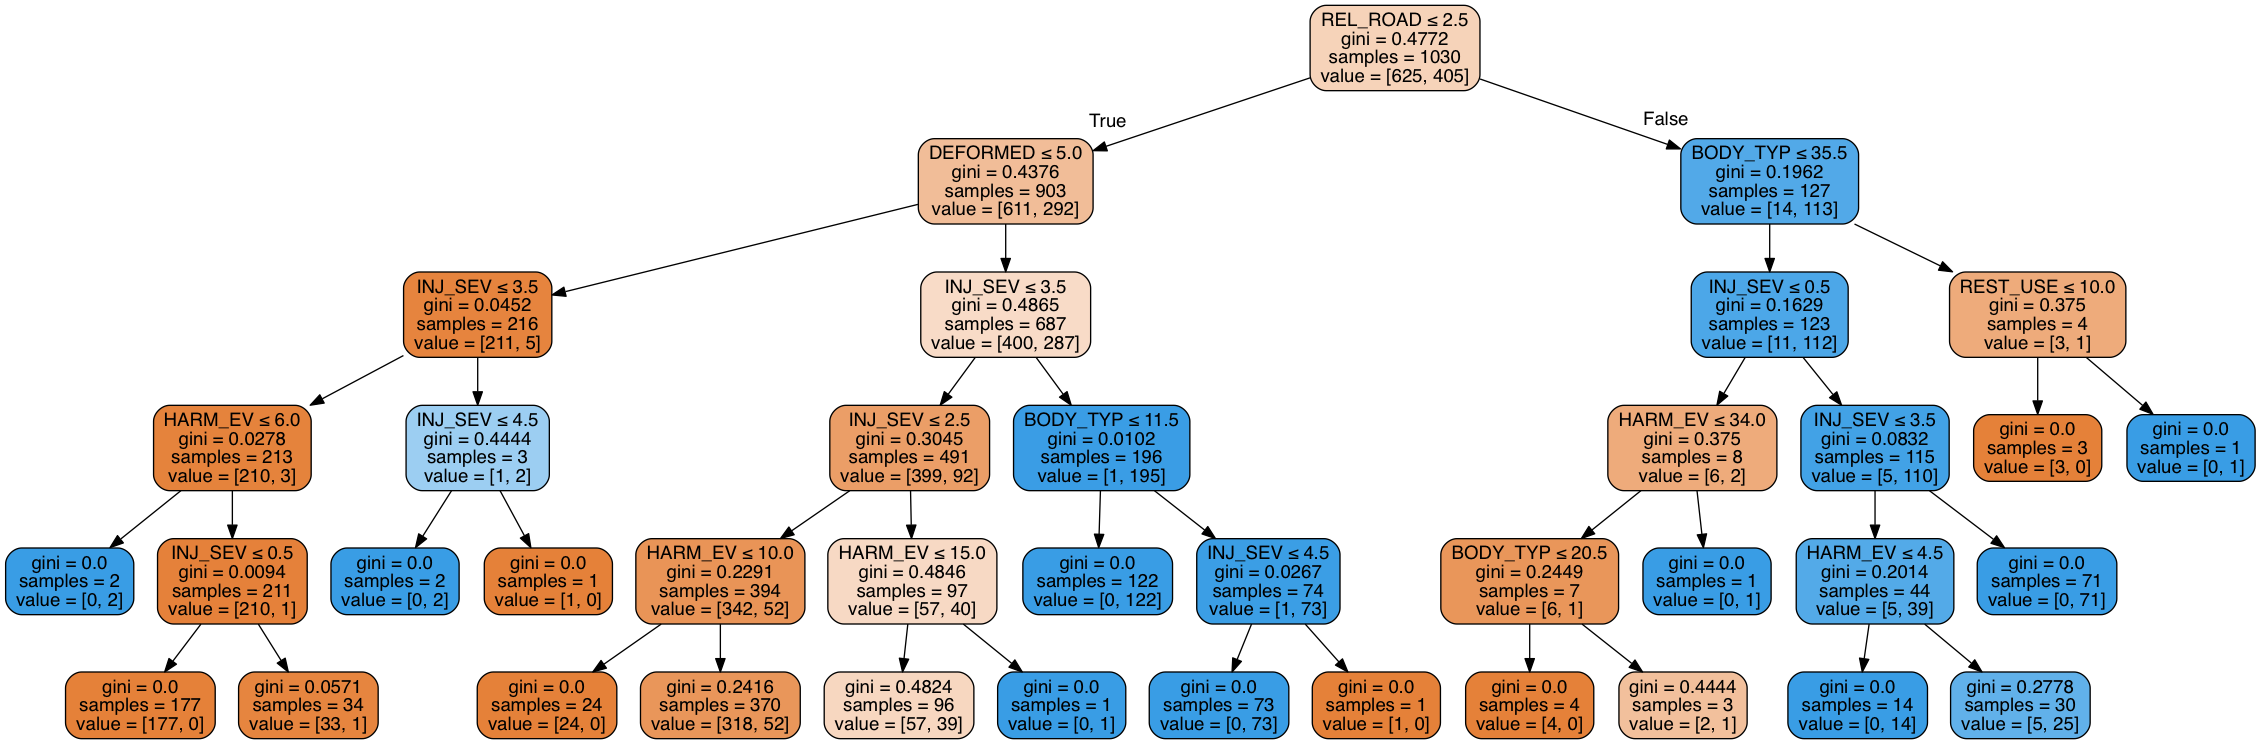

In [204]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot_ng as pydot

dot_data = StringIO()  
export_graphviz(dtr, out_file=dot_data,  
                feature_names=X.columns,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Decision tree with all X columns

In [205]:
X = df_vehicle_accident_person_merged[['HOUR', 'ROUTE', 'HARM_EV', 'MAN_COLL', 'TYP_INT', 'REL_ROAD', 'WEATHER2', 'ARR_HOUR', 
'TRAV_SP', 'ROLLOVER', 'DEFORMED', 'M_HARM', 'SPEEDREL', 'VNUM_LAN', 'VALIGN', 'ACC_TYPE', 
'AGE', 'INJ_SEV', 'NUMOCCS', 'HIT_RUN', 'BODY_TYP', 'TOW_VEH', 'J_KNIFE', 'GVWR', 
'REST_USE', 'AIR_BAG','EJECTION' ,'EJ_PATH']]
Y = df_vehicle_accident_person_merged.DEATHS_BINARY
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3) #train_test_split(X, Y, test_size=0.33)

dtr = sklearn.tree.DecisionTreeClassifier(max_depth=5, max_features=5)
dtr.fit(X_train,Y_train)
dtr_pred = dtr.predict(X_test)
dtr_proba = dtr.predict_proba(X_test)

print sk.metrics.classification_report(Y_test, dtr_pred)
print sk.metrics.confusion_matrix(y_true=Y_test, y_pred=dtr_pred)
print sk.metrics.accuracy_score(y_true=Y_test, y_pred=dtr_pred)
# logreg.feature_importances_

             precision    recall  f1-score   support

          0       0.88      0.90      0.89       261
          1       0.85      0.82      0.83       181

avg / total       0.87      0.87      0.87       442

[[235  26]
 [ 33 148]]
0.866515837104


In [206]:
cm_logreg_all_vars = pd.DataFrame(sk.metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred), columns=['Predicted_0', 'Predicted_1'], index=['True_0','True_1'])
cm_logreg_all_vars

,Predicted_0,Predicted_1
True_0,166,95
True_1,118,63


0.912141995301


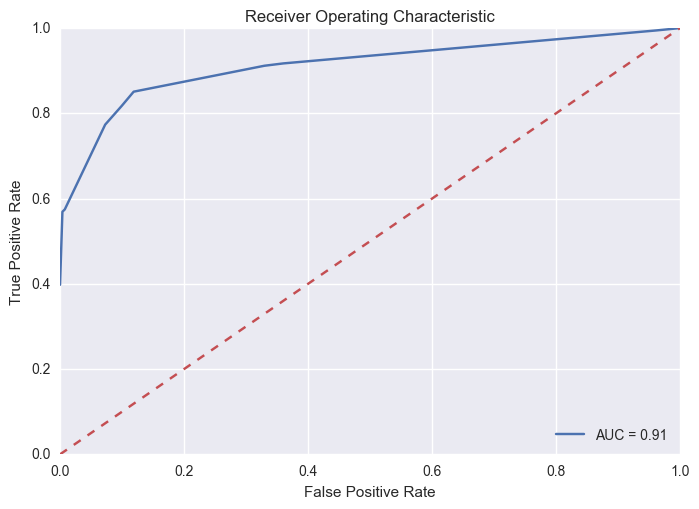

In [207]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test,  dtr_proba[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
# print fpr
# print tpr
# print threshold
print roc_auc

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_curve_decision_tree_all_vars.png')
plt.show()


In [208]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot_ng as pydot

In [209]:
X = df_vehicle_accident_person_merged[['HOUR', 'ROUTE', 'HARM_EV', 'MAN_COLL', 'TYP_INT', 'REL_ROAD', 'WEATHER2', 'ARR_HOUR', 
'TRAV_SP', 'ROLLOVER', 'DEFORMED', 'M_HARM', 'SPEEDREL', 'VNUM_LAN', 'VALIGN', 'ACC_TYPE', 
'AGE', 'INJ_SEV', 'NUMOCCS', 'HIT_RUN', 'BODY_TYP', 'TOW_VEH', 'J_KNIFE', 'GVWR', 
'REST_USE', 'AIR_BAG','EJECTION' ,'EJ_PATH']]
Y = df_vehicle_accident_person_merged.DEATHS_BINARY
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3) #train_test_split(X, Y, test_size=0.33)

dtr = sklearn.tree.DecisionTreeClassifier(max_depth=3, max_features=5)
dtr.fit(X_train,Y_train)
dtr_pred = dtr.predict(X_test)
dtr_proba = dtr.predict_proba(X_test)

print sk.metrics.classification_report(Y_test, dtr_pred)
print sk.metrics.confusion_matrix(y_true=Y_test, y_pred=dtr_pred)
print sk.metrics.accuracy_score(y_true=Y_test, y_pred=dtr_pred)
# logreg.feature_importances_

             precision    recall  f1-score   support

          0       0.69      0.99      0.81       274
          1       0.96      0.27      0.42       168

avg / total       0.79      0.72      0.66       442

[[272   2]
 [123  45]]
0.717194570136


In [210]:
params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}

gsdt = GridSearchCV(dtr,
                    params, n_jobs=-1,
                    cv=KFold(len(Y), n_folds=3, shuffle=True))

gsdt.fit(X, Y)
print gsdt.best_params_
print gsdt.best_score_

{'min_samples_split': 2, 'splitter': 'best', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3}
0.913722826087


# Optimized Decision Tree!

In [211]:
X = df_vehicle_accident_person_merged[['HOUR', 'ROUTE', 'HARM_EV', 'MAN_COLL', 'TYP_INT', 'REL_ROAD', 'WEATHER2', 'ARR_HOUR', 
'TRAV_SP', 'ROLLOVER', 'DEFORMED', 'M_HARM', 'SPEEDREL', 'VNUM_LAN', 'VALIGN', 'ACC_TYPE', 
'AGE', 'INJ_SEV', 'NUMOCCS', 'HIT_RUN', 'BODY_TYP', 'TOW_VEH', 'J_KNIFE', 'GVWR', 
'REST_USE', 'AIR_BAG','EJECTION' ,'EJ_PATH']]
Y = df_vehicle_accident_person_merged.DEATHS_BINARY
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3) #train_test_split(X, Y, test_size=0.33)

dtr = sklearn.tree.DecisionTreeClassifier(min_samples_split=2, criterion='entropy', max_depth= 10, min_samples_leaf=2)
dtr.fit(X_train,Y_train)
dtr_pred = dtr.predict(X_test)
dtr_proba = dtr.predict_proba(X_test)

print sk.metrics.classification_report(Y_test, dtr_pred)
print sk.metrics.confusion_matrix(y_true=Y_test, y_pred=dtr_pred)
print sk.metrics.accuracy_score(y_true=Y_test, y_pred=dtr_pred)
# logreg.feature_importances_

             precision    recall  f1-score   support

          0       0.91      0.95      0.93       280
          1       0.91      0.85      0.88       162

avg / total       0.91      0.91      0.91       442

[[267  13]
 [ 25 137]]
0.914027149321


0.93330026455


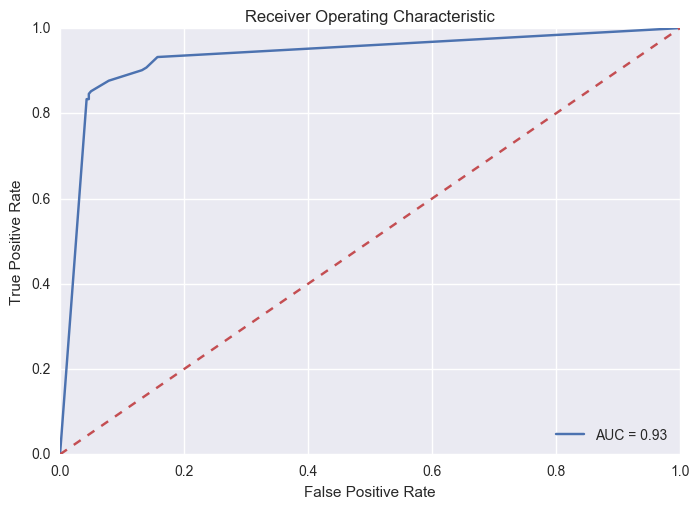

In [212]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test,  dtr_proba[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
# print fpr
# print tpr
# print threshold
print roc_auc

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_curve_decision_tree_all_vars.png')
plt.show()


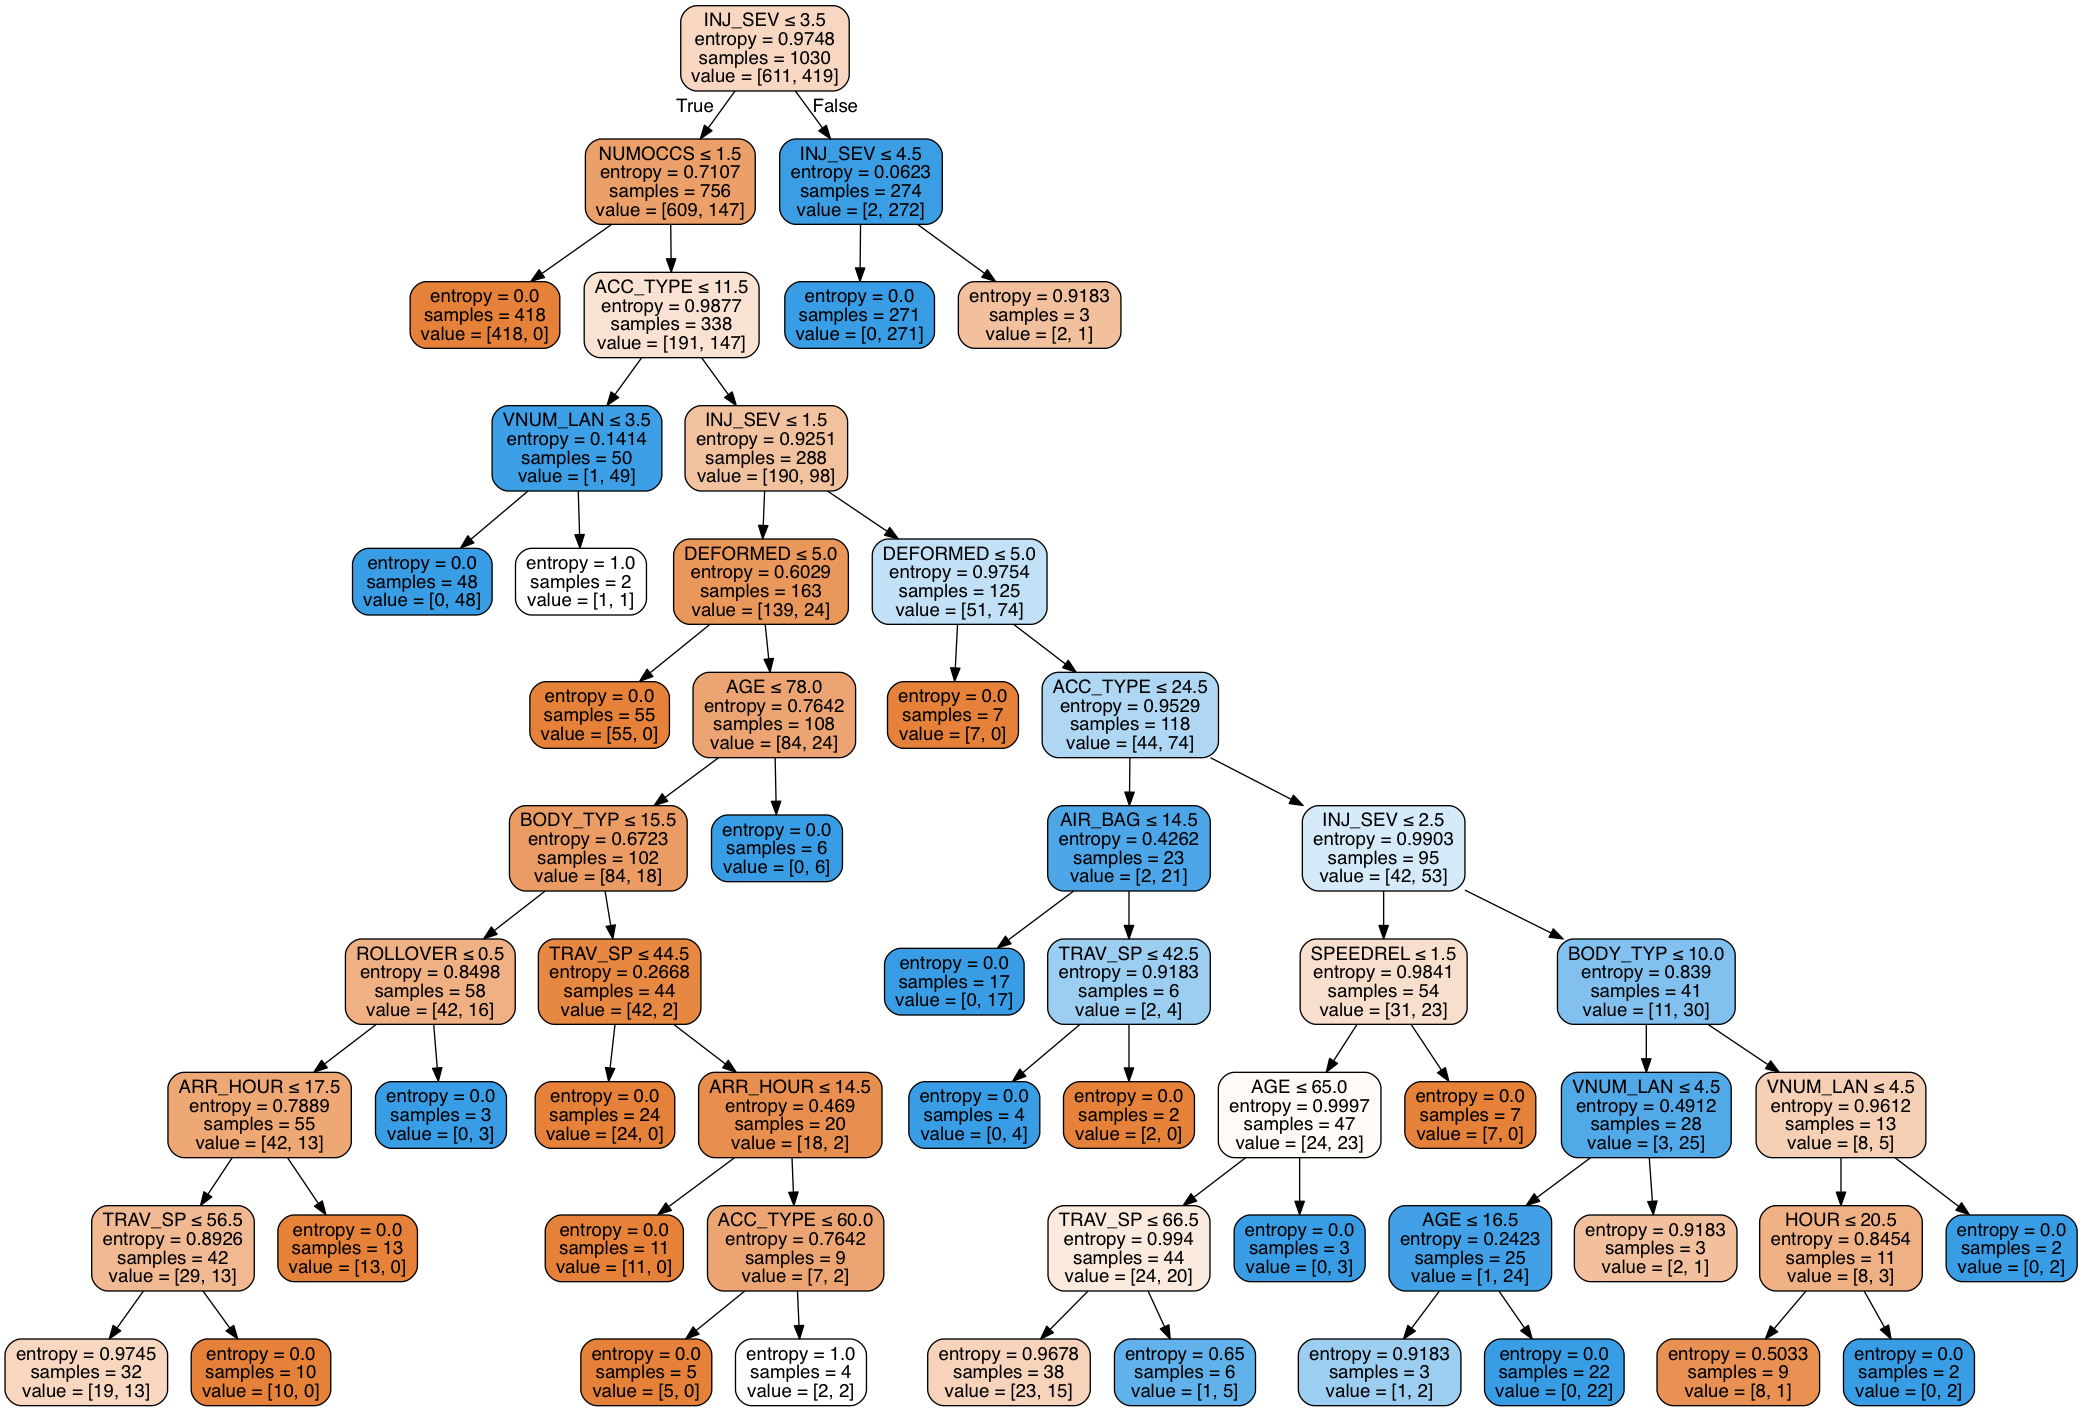

In [213]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot_ng as pydot

dot_data = StringIO()  
export_graphviz(dtr, out_file=dot_data,  
                feature_names=X.columns,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

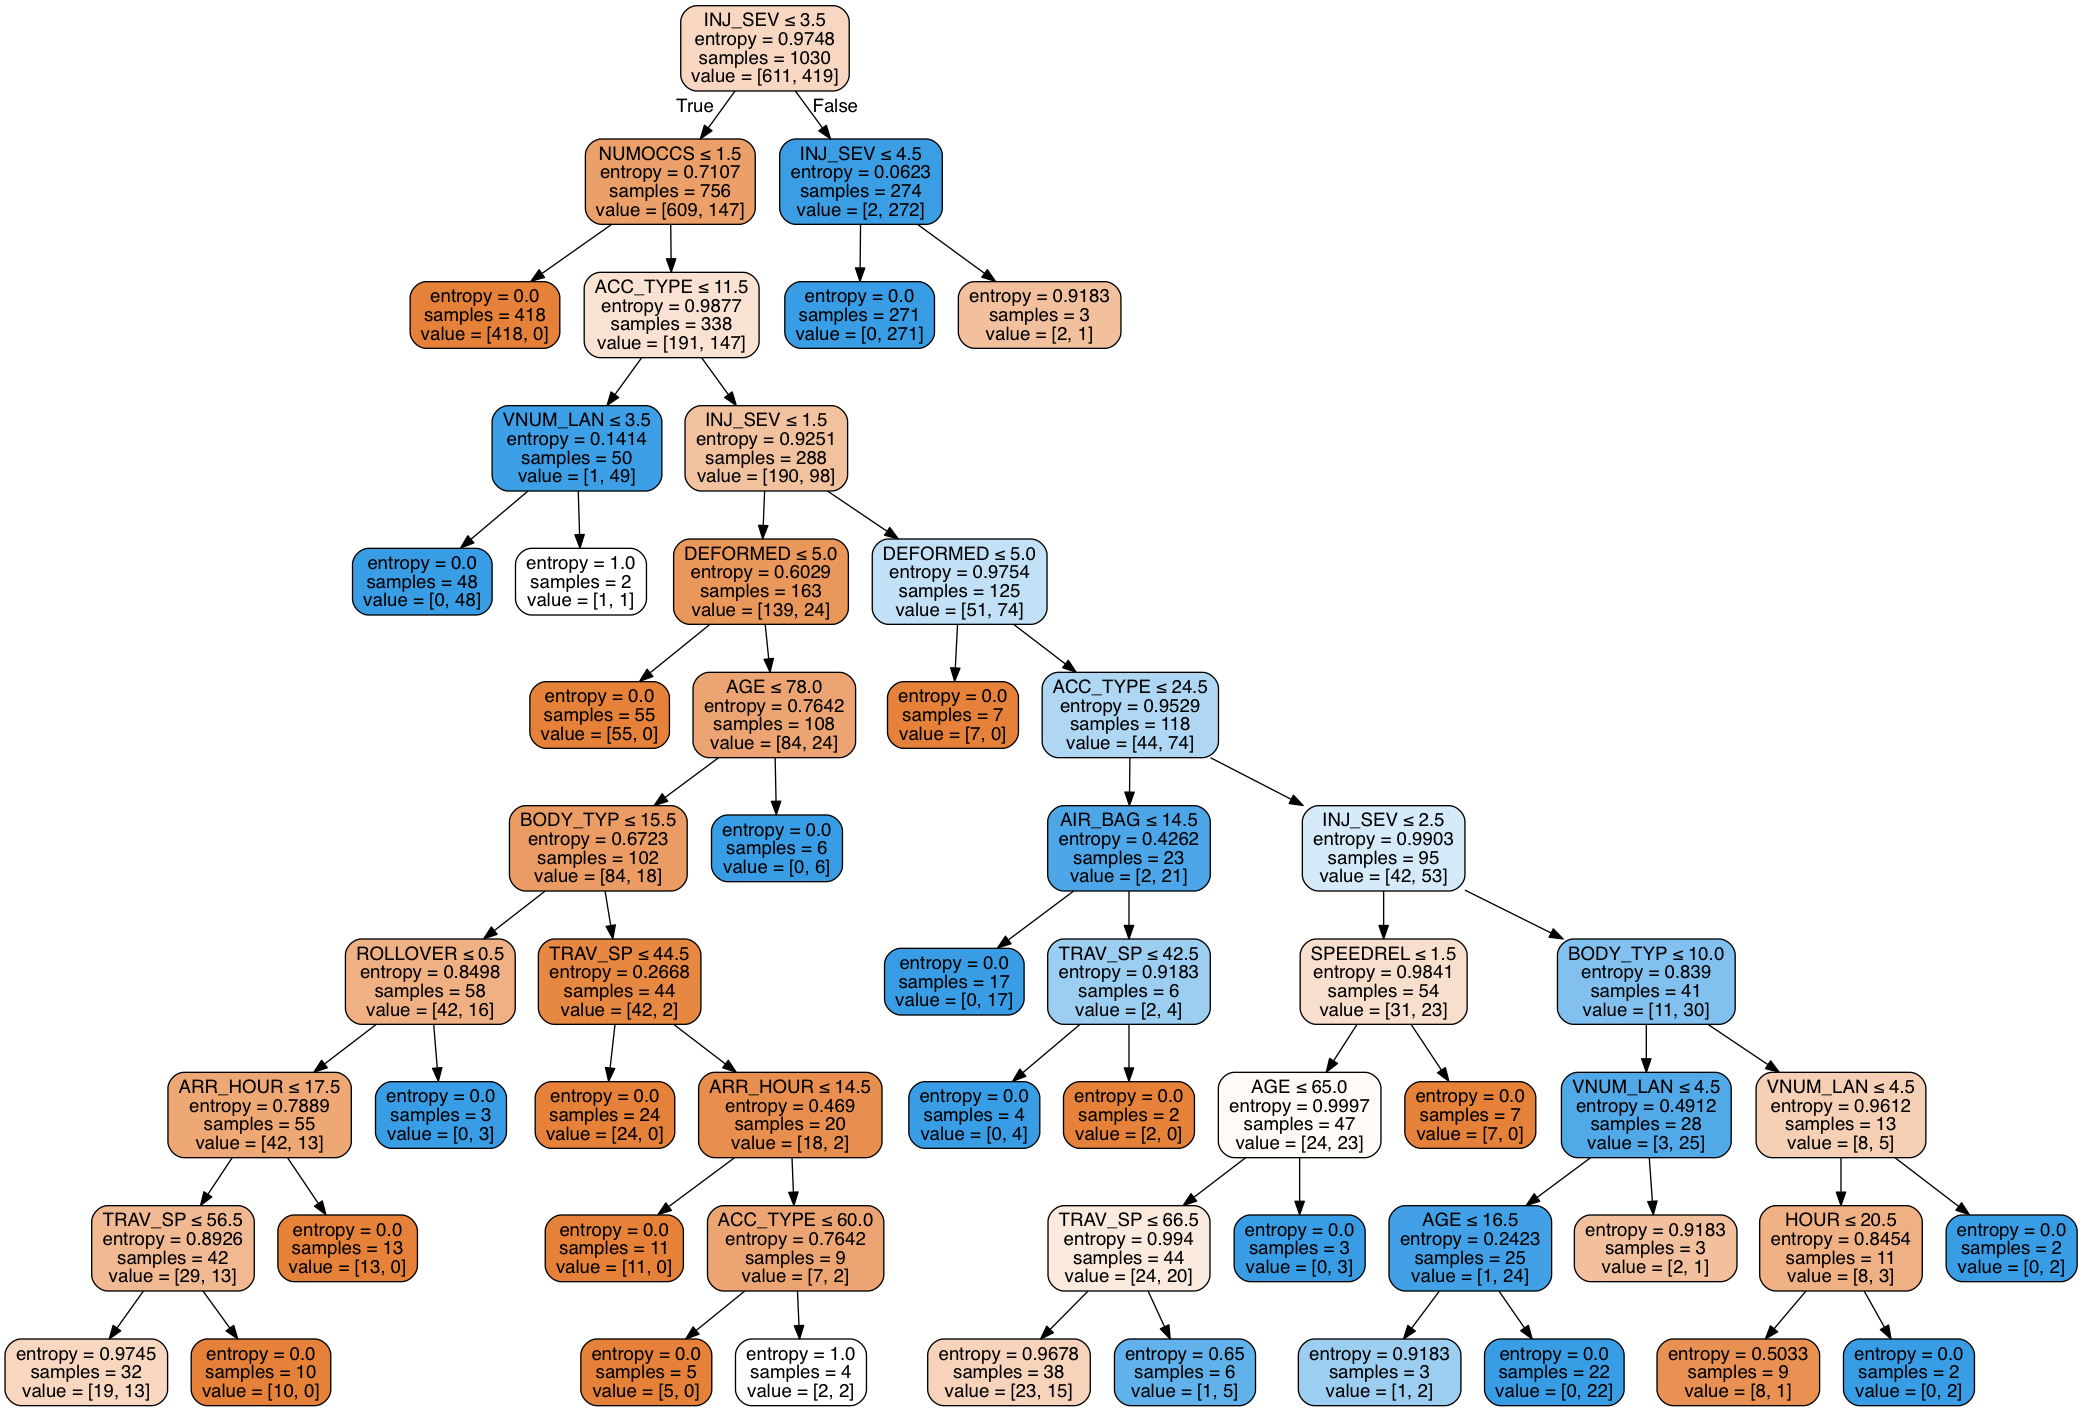

In [214]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot_ng as pydot

dot_data = StringIO()  
export_graphviz(dtr, out_file=dot_data,  
                feature_names=X.columns,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#  SVM!!!! 

In [215]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, Y_train)
svm_pred = svm.predict(X_test)
print svm.score(X, Y)

0.890625


In [216]:
params = {'C': [0.01, 0.1, 1.0],
          'gamma': ['auto', 0.1, 1.0],
          'kernel': ['linear', 'rbf']}


gssvm = GridSearchCV(svm,
                    params, n_jobs=-1,
                    cv=KFold(len(Y), n_folds=3, shuffle=True))

gssvm.fit(X, Y)
print gssvm.best_params_
print gssvm.best_score_
print sk.metrics.classification_report(Y_test, svm_pred)
print sk.metrics.confusion_matrix(y_true=Y_test, y_pred=svm_pred)
print sk.metrics.accuracy_score(y_true=Y_test, y_pred=svm_pred)

{'kernel': 'linear', 'C': 1.0, 'gamma': 'auto'}
0.896059782609
             precision    recall  f1-score   support

          0       0.64      0.98      0.77       280
          1       0.54      0.04      0.08       162

avg / total       0.60      0.64      0.52       442

[[274   6]
 [155   7]]
0.635746606335


In [217]:
svm = SVC(kernel='linear', C = 0.01, gamma='auto')
svm.fit(X_train, Y_train)
svm_pred = svm.predict(X_test)
print svm.score(X_test, Y_test)

0.889140271493


0.93330026455


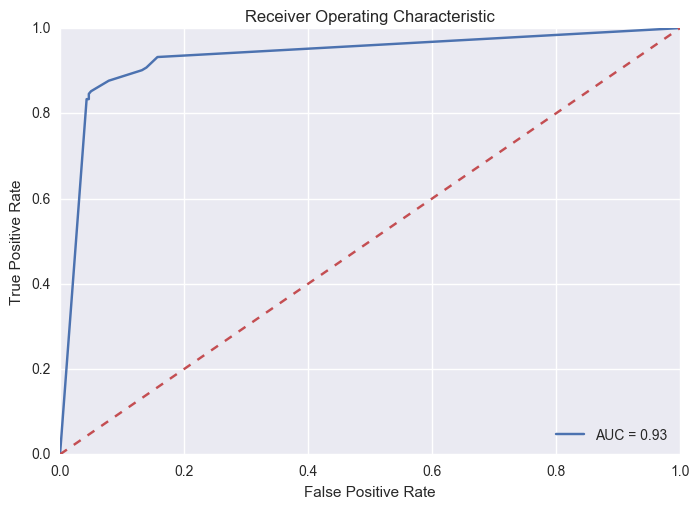

In [218]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test,  dtr_proba[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
# print fpr
# print tpr
# print threshold
print roc_auc

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_curve_optimized_SVM_all_vars.png')
plt.show()


# Try doing KNN Definitely need GridSearch

In [219]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
baggingknn = BaggingClassifier(KNeighborsClassifier())
bagging_params = {'n_estimators': [10, 20],
                  'max_samples': [0.7, 1.0],
                  'max_features': [0.7, 1.0],
                  'bootstrap_features': [True, False]}


gsbaggingknn = GridSearchCV(baggingknn,
                            bagging_params, n_jobs=-1,
                            cv=KFold(len(Y), n_folds=3, shuffle=True))

gsbaggingknn.fit(X,Y)
print gsbaggingknn.best_estimator_
print gsbaggingknn.best_params_
print gsbaggingknn.best_score_

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=True, max_features=0.7,
         max_samples=0.7, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
{'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 20, 'bootstrap_features': True}
0.821331521739


0.93330026455


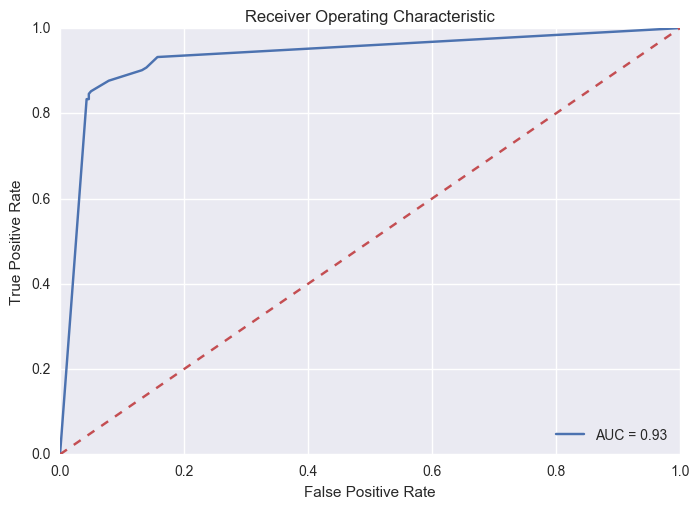

In [220]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test,  dtr_proba[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
# print fpr
# print tpr
# print threshold
print roc_auc

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_curve_optimized_bagging_SVM_all_vars.png')
plt.show()
